In [1]:
import networkx as nx
import nx_arangodb as nxadb

from arango import ArangoClient

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import randint
import re

from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from langchain_community.graphs import ArangoGraph
from langchain_community.chains.graph_qa.arangodb import ArangoGraphQAChain
from langchain_core.tools import tool


import gradio
from graph_utils import create_d3_visualization
from dotenv import load_dotenv
import os
from agent_utils import GraphAgent



[02:14:40 -0600] [INFO]: NetworkX-cuGraph is unavailable: No module named 'nx_cugraph'.


In [2]:
load_dotenv()

True

In [3]:
# Access variables
openai_key = os.getenv('OPENAI_API_KEY')
arango_host = os.getenv('ARANGO_HOST')
arango_user = os.getenv('ARANGO_USER')
arango_password = os.getenv('ARANGO_PASSWORD')
arango_db = os.getenv('ARANGO_DB')


In [4]:
# Initialize the client for ArangoDB.
client = ArangoClient(hosts=arango_host)
db = client.db(arango_db, username=arango_user, password=arango_password)
print(db.collections())

[{'id': '195136', 'name': '_analyzers', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '195138', 'name': '_queues', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '195137', 'name': '_aqlfunctions', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '211044', 'name': 'Users', 'system': False, 'type': 'document', 'status': 'loaded'}, {'id': '195139', 'name': '_jobs', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '211045', 'name': 'Games', 'system': False, 'type': 'document', 'status': 'loaded'}, {'id': '195141', 'name': '_appbundles', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '195135', 'name': '_graphs', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '195140', 'name': '_apps', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '211046', 'name': 'plays', 'system': False, 'type': 'edge', 'status': 'loaded'}, {'id': '195142', 'name': '_frontend', 'system': True, 'type': 'docu

In [5]:

G_adb = nxadb.Graph(name="SteamGraph", db=db)

print(G_adb)

[02:14:43 -0600] [INFO]: Graph 'SteamGraph' exists.
[02:14:43 -0600] [INFO]: Default node type set to 'Games'


Graph named 'SteamGraph' with 14950 nodes and 70477 edges


In [6]:
graph_def = db.collection("_graphs").get("SteamGraph")
print(graph_def)


{'_key': 'SteamGraph', '_id': '_graphs/SteamGraph', '_rev': '_jPzEASO---', 'edgeDefinitions': [{'collection': 'plays', 'from': ['Users'], 'to': ['Games']}], 'orphanCollections': [], 'networkx': {'name': 'SteamGraph'}}


In [7]:
for node, data in list(G_adb.nodes(data=True))[:10]:
    print(node, data.get("_id"))


Users/244722763 Users/244722763
Users/130312302 Users/130312302
Games/11951_full_spectrum_warrior_ten_hammers Games/11951_full_spectrum_warrior_ten_hammers
Users/212426459 Users/212426459
Games/12433_primordia Games/12433_primordia
Users/140708070 Users/140708070
Users/11373749 Users/11373749
Games/12335_party_of_sin Games/12335_party_of_sin
Users/152959594 Users/152959594
Users/214900977 Users/214900977


In [8]:
print(G_adb)

Graph named 'SteamGraph' with 14950 nodes and 70477 edges


### AQL Test

In [9]:
# First, let's check what collections exist
print("Available collections:")
for collection in db.collections():
    print(collection['name'])

# Get the graph to see its collections
graph = db.graph('SteamGraph')
print("\nGraph collections:")
print(graph.edge_definitions())

Available collections:
_analyzers
_queues
_aqlfunctions
Users
_jobs
Games
_appbundles
_graphs
_apps
plays
_frontend

Graph collections:
[{'edge_collection': 'plays', 'from_vertex_collections': ['Users'], 'to_vertex_collections': ['Games']}]


In [10]:


# -----------------------------------------------------------
# 1. Query 3 random nodes from the Users collection.
# -----------------------------------------------------------
result_cursor = G_adb.query("""
    FOR node IN Users
        SORT RAND()
        LIMIT 3
        RETURN node
""")
print("Sample Users Nodes:")
for node in result_cursor:
    print(node)
print('-'*10)

# -----------------------------------------------------------
# 2. Query 3 random edges from the plays edge collection.
# -----------------------------------------------------------
result_cursor = G_adb.query("""
    FOR edge IN plays
        SORT RAND()
        LIMIT 3
        RETURN edge
""")
print("Sample Plays Edges:")
for edge in result_cursor:
    print(edge)
print('-'*10)


Sample Users Nodes:
{'_key': '198680785', '_id': 'Users/198680785', '_rev': '_jPaYbkW--B', 'type': 'Users', 'steamid': 198680785}
{'_key': '27579751', '_id': 'Users/27579751', '_rev': '_jPaYbqS-_V', 'type': 'Users', 'steamid': 27579751}
{'_key': '72207742', '_id': 'Users/72207742', '_rev': '_jPaYbiK-_D', 'type': 'Users', 'steamid': 72207742}
----------
Sample Plays Edges:
{'_key': '11892', '_id': 'plays/11892', '_from': 'Users/43565258', '_to': 'Games/11359_team_fortress_2', '_rev': '_jPaYfkS--c', 'weight': 1.2}
{'_key': '13491', '_id': 'plays/13491', '_from': 'Users/105782521', '_to': 'Games/12421_call_of_duty_ghosts_multiplayer', '_rev': '_jPaYfwu--q', 'weight': 32}
{'_key': '48155', '_id': 'plays/48155', '_from': 'Users/129117376', '_to': 'Games/12815_narcissu_1st_2nd', '_rev': '_jPaYhny--h', 'weight': 0.4}
----------


### Agent

In [11]:
arango_graph = ArangoGraph(db)


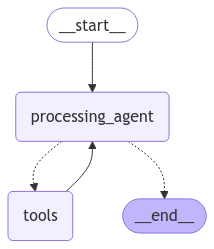

In [12]:
agent = GraphAgent(arango_graph, G_adb)


In [19]:
agent.query_graph("Find 2nd and 4th Most influential game in the graph and its number of users who played both of them")

Netwrokx Query received:
Find the most influential games in the graph using centrality measures.
----------
1) Generating NetworkX code
----------
import networkx as nx

# Assuming G_adb is already defined and is a NetworkX graph object

# Step 1: Calculate degree centrality for games
degree_centrality = nx.degree_centrality(G_adb)

# Step 2: Filter out the centrality values for games only
games_centrality = {node: centrality for node, centrality in degree_centrality.items() if G_adb.nodes[node]['type'] == 'Games'}

# Step 3: Find the game with the highest centrality
most_influential_game = max(games_centrality, key=games_centrality.get)

# Step 4: Retrieve the game name
FINAL_RESULT = G_adb.nodes[most_influential_game]['GameName']
----------

2) Executing NetworkX code


[02:20:33 -0600] [INFO]: Graph 'SteamGraph' load took 2.248645544052124s


----------
FINAL_RESULT: Dota 2
----------
3) Formulating final answer
Netwrokx Query received:
List the top influential games in the graph based on centrality measures to identify the 2nd and 4th most influential games.
----------
1) Generating NetworkX code
----------
import networkx as nx

# Calculate degree centrality for the graph
degree_centrality = nx.degree_centrality(G_adb)

# Filter out only the 'Games' nodes
games_centrality = {node: centrality for node, centrality in degree_centrality.items() if G_adb.nodes[node]['type'] == 'Games'}

# Sort games by centrality in descending order
sorted_games = sorted(games_centrality.items(), key=lambda item: item[1], reverse=True)

# Get the 2nd and 4th most influential games
second_most_influential_game = sorted_games[1][0] if len(sorted_games) > 1 else None
fourth_most_influential_game = sorted_games[3][0] if len(sorted_games) > 3 else None

# Prepare the final result
FINAL_RESULT = (second_most_influential_game, fourth_most_influential

[02:20:43 -0600] [INFO]: Graph 'SteamGraph' load took 2.478921413421631s


----------
FINAL_RESULT: ('Games/11359_team_fortress_2', 'Games/11590_unturned')
----------
3) Formulating final answer
Query Received for AQL translation:
Find the number of users who have played both 'Team Fortress 2' and 'Unturned'.
----------


> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH Users, Games, plays

LET teamFortress2 = FIRST(FOR game IN Games FILTER game.GameName == 'Team Fortress 2' RETURN game._id)
LET unturned = FIRST(FOR game IN Games FILTER game.GameName == 'Unturned' RETURN game._id)

LET usersPlayingBoth = (
    FOR user IN Users
        FILTER LENGTH(
            FOR play IN plays
                FILTER play._from == user._id AND (play._to == teamFortress2 OR play._to == unturned)
                RETURN 1
        ) == 2
        RETURN user
)

RETURN LENGTH(usersPlayingBoth)

AQL Result:
[500]

> Finished chain.
Arrango Chain Result:
{'query': "Find the number of users who have played both 'Team Fortress 2' and 'Unturned'.", 'result': "The number 

'The number of users who have played both "Team Fortress 2" and "Unturned" is 500. \n\nTo summarize:\n- The 2nd most influential game is "Team Fortress 2".\n- The 4th most influential game is "Unturned".\n- 500 users have played both of these games.'

In [20]:
agent.query_graph("Find the  top 10 users who played a lot  and which games they have played is common most by hours")

Query Received for AQL translation:
SELECT user_id, SUM(hours_played) as total_hours FROM user_game_data GROUP BY user_id ORDER BY total_hours DESC LIMIT 10
----------


> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH Users, Games, plays
FOR user IN Users
    LET total_hours = SUM(
        FOR play IN plays
            FILTER play._from == user._id
            RETURN play.weight
    )
    SORT total_hours DESC
    LIMIT 10
    RETURN { user_id: user._key, total_hours: total_hours }

AQL Result:
[{'user_id': '73017395', 'total_hours': 11754}, {'user_id': '10599862', 'total_hours': 11651.699999999999}, {'user_id': '100630947', 'total_hours': 10853.2}, {'user_id': '26762388', 'total_hours': 10470.100000000004}, {'user_id': '153382649', 'total_hours': 9640}, {'user_id': '43684632', 'total_hours': 9546.299999999988}, {'user_id': '48798067', 'total_hours': 9427.199999999997}, {'user_id': '52731290', 'total_hours': 9417.6}, {'user_id': '42935819', 'total_hours': 8172.9}, {'user

"Here are the games that the top 10 users have played the most in common, based on the total hours spent:\n\n1. **Sid Meier's Civilization V**: 13,197 hours\n2. **Dota 2**: 10,790.4 hours\n3. **Team Fortress 2**: 9,724.7 hours\n4. **Counter-Strike: Global Offensive**: 5,434.6 hours\n5. **Mount & Blade: Warband**: 4,962 hours\n6. **Baldur's Gate II: Enhanced Edition**\n7. **Football Manager 2014**\n\nThese games are the most commonly played among the top 10 users by total playtime."